In [2]:
#preparation

import torch
!pip install torchaudio
import torchaudio
import numpy as np
print(torch.__version__)
print(torchaudio.__version__)
torch.random.manual_seed(0)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.4.0+cu121
2.4.0+cu121
cpu


In [3]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
Speech_file=download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

100%|██████████| 106k/106k [00:00<00:00, 3.83MB/s]


In [4]:
#creating_a_pipeline
#we_will_use_torchaudio.pipelines.Wav2Vec2_ASR_BASE_960H
#sampling_rate_and_class_labels_are_found_as

bundle=torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Class Labels:", bundle.get_labels)


Sample Rate: 16000
Class Labels: <bound method Wav2Vec2ASRBundle.get_labels of Wav2Vec2ASRBundle(_path='wav2vec2_fairseq_base_ls960_asr_ls960.pth', _params={'extractor_mode': 'group_norm', 'extractor_conv_layer_config': [(512, 10, 5), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 2, 2), (512, 2, 2)], 'extractor_conv_bias': False, 'encoder_embed_dim': 768, 'encoder_projection_dropout': 0.1, 'encoder_pos_conv_kernel': 128, 'encoder_pos_conv_groups': 16, 'encoder_num_layers': 12, 'encoder_num_heads': 12, 'encoder_attention_dropout': 0.1, 'encoder_ff_interm_features': 3072, 'encoder_ff_interm_dropout': 0.0, 'encoder_dropout': 0.1, 'encoder_layer_norm_first': False, 'encoder_layer_drop': 0.05, 'aux_num_out': 29}, _sample_rate=16000, _normalize_waveform=False, _model_type='Wav2Vec2', _labels=('|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z'), _remove_aux_axis=(1, 2, 3))>


In [5]:
print("Class Labels:", bundle.get_labels())

Class Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [6]:
#Model_construction_automatically_fetch_pre-trained_weights_and_load_into_model
model=bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:02<00:00, 147MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [7]:
#loading_data

IPython.display.Audio(Speech_file)

In [8]:
waveform, sample_rate=torchaudio.load(Speech_file)
waveform=waveform.to(device)
if sample_rate!=bundle.sample_rate:
  waveform=torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [9]:
#Extracting_acoustic_features
with torch.inference_mode():
  feature, _ = model.extract_features(waveform)

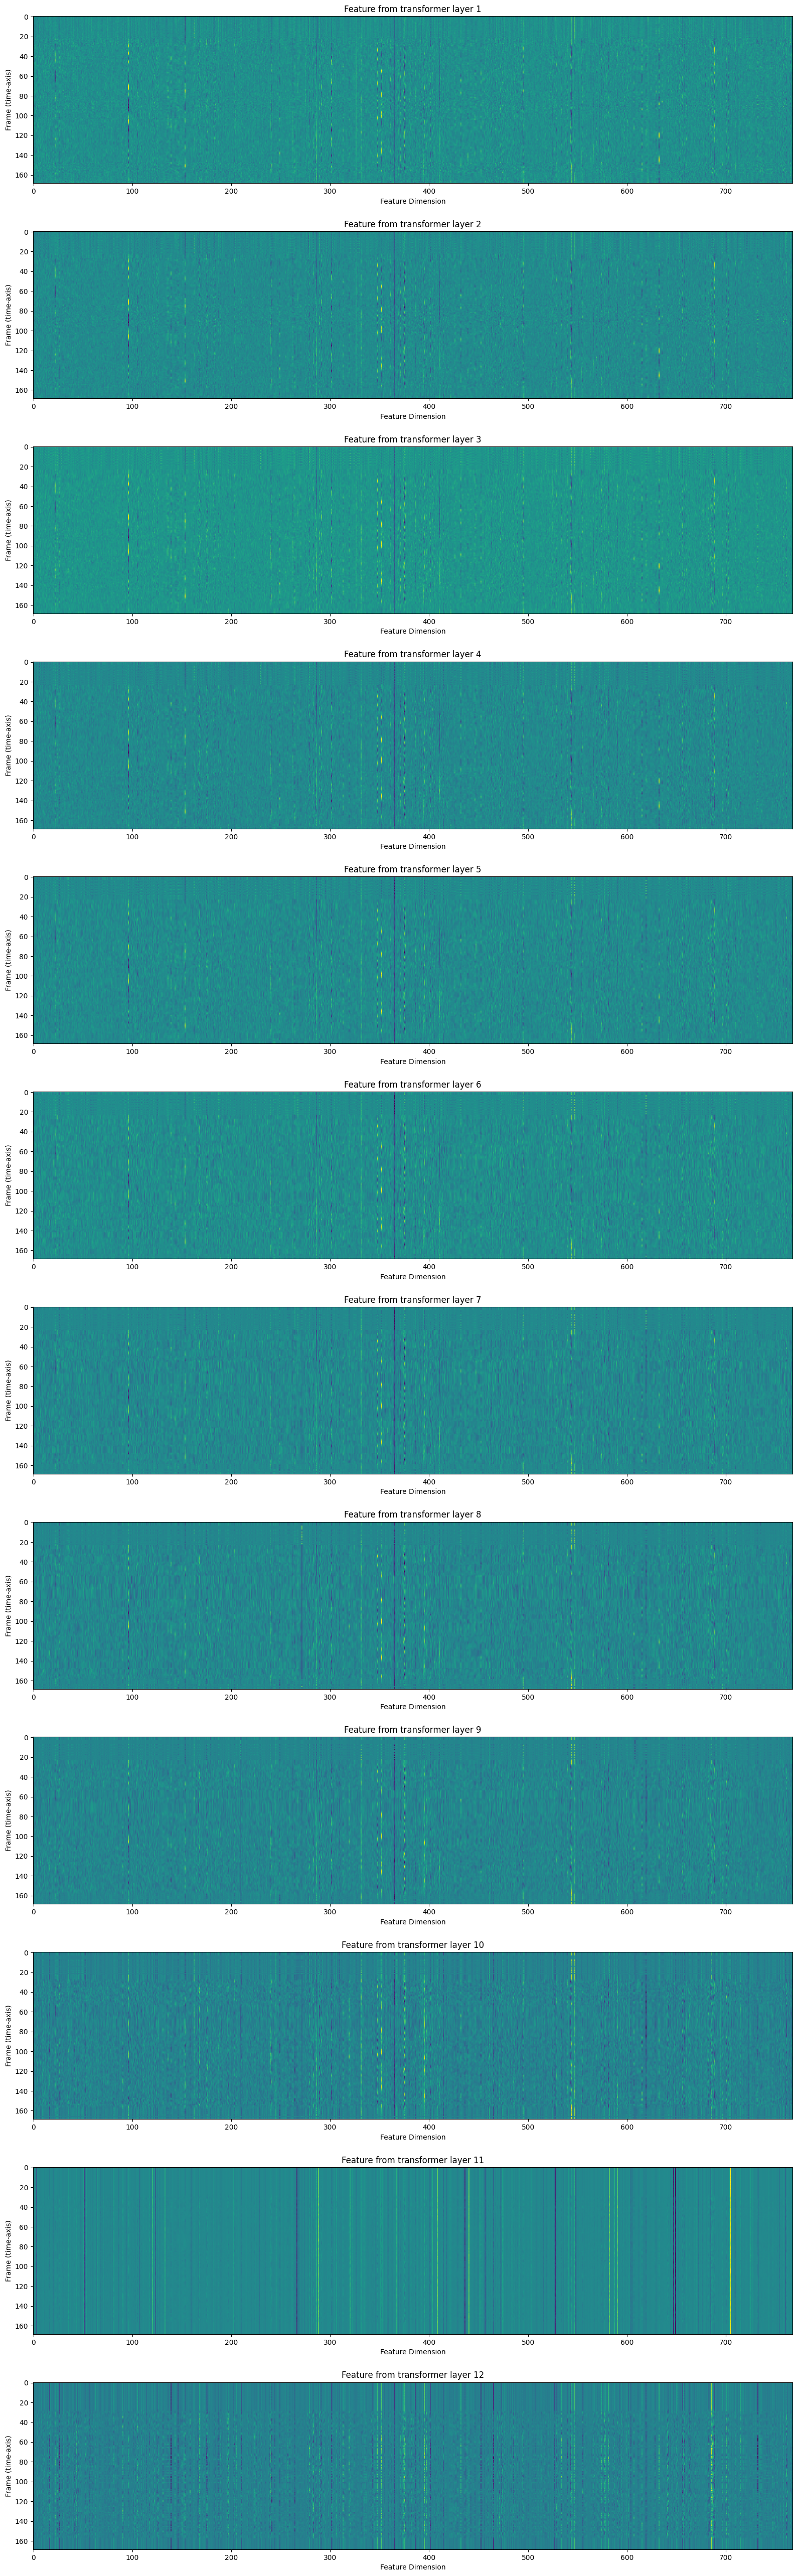

In [10]:
#Returned_features_is_list_of_tensors_each_is_output_of_transformer_layer
fig, ax = plt.subplots(len(feature), 1, figsize=(16, 4.3 * len(feature)))
for i, feats in enumerate(feature):
  ax[i].imshow(feats[0].cpu(), interpolation="nearest")
  ax[i].set_title(f"Feature from transformer layer {i+1}")
  ax[i].set_xlabel("Feature Dimension")
  ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()


In [11]:
#Feature_Classification

with torch.inference_mode():
  emission, _ = model(waveform) #output_is_in_form_of_logits

Class Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


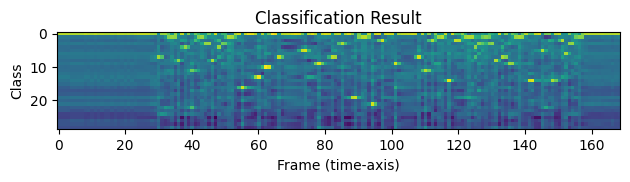

In [12]:
#Visualise_above_output

plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification Result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class Labels:", bundle.get_labels())

In [14]:
#Genarating_Transcripts
#Greedy_Decoding_does-not_depend_on_external_components_simply_pick_best_hypothesis_at_each_time_stamp_therefore_context_information_are_not_used_only_one
#transcript_is_generated
#Greedy_Decoding_Algorithm

class greedyCTCDecoder(torch.nn.Module):
  def __init__(self, labels, blank=0):
    super().__init__()
    self.labels=labels
    self.blank=blank

  def forward(self, emission:torch.tensor)->str:
    """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
    """
    indices=torch.argmax(emission, dim=-1)
    indices=torch.unique_consecutive(indices, dim=-1)
    indices=[i for i in indices if i!=self.blank]
    return " ".join([self.labels[i] for i in indices])


In [15]:
#Decoder_object_and_decode_the_transcript
decoder=greedyCTCDecoder(labels=bundle.get_labels())
transcript=decoder(emission[0])

In [16]:
print(transcript)
IPython.display.Audio(Speech_file)

I | H A D | T H A T | C U R I O S I T Y | B E S I D E | M E | A T | T H I S | M O M E N T |
